In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random, time
import pickle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# set to ignore warning
pd.set_option('mode.chained_assignment', None)

In [2]:
# load CND data
CND = pd.read_csv('../Data/Compressed_NFL_Data_Pre2020.csv')

In [3]:
# use OrdinalEncoder to transform team and opp to numeric value
ord_enc = OrdinalEncoder()
CND['team_code'] = ord_enc.fit_transform(CND[['team']])
CND.team_code = CND.team_code.astype(int)
CND['opp_code'] = ord_enc.fit_transform(CND[['opp']])
CND.opp_code = CND.opp_code.astype(int)
Codes = CND[['team', 'team_code', 'opp', 'opp_code']]

In [4]:
# drop 'Team' and 'Opp' since they are now encoded
CND.drop(['team', 'opp'], axis = 1, inplace = True)
CND.head()

,season,week,game,day,time,tm_off_bye,opp_off_bye,tm_btwn_gms,opp_btwn_gms,h_or_a,...,opp_over_streak,result,team_score,opp_score,spread,spread_outcome,over/under,ou_result,team_code,opp_code
0,2010,2,2,0,0,0,0,7,7,1,...,0.0,0,7.0,34.0,13.0,0,43.0,0,3,11
1,2010,3,3,0,0,0,0,7,7,1,...,2.0,0,30.0,38.0,14.5,1,43.0,1,3,21
2,2010,4,4,0,0,0,0,7,7,0,...,2.0,0,14.0,38.0,6.0,0,37.0,1,3,24
3,2010,5,5,0,0,0,0,7,7,0,...,1.0,0,26.0,36.0,-2.5,0,41.5,1,3,14
4,2010,7,6,0,0,1,0,14,7,1,...,0.0,0,34.0,37.0,12.5,1,40.0,1,3,2


In [5]:
# seperate features and target
# X is feature matrix
X = CND.drop(['result', 'ou_result', 'spread_outcome', 'team_score', 'opp_score'], axis = 1)

# y is target
y = CND['result']

In [6]:
# normalize data using StandardScaler
scaler = StandardScaler()
names = X.columns
d = scaler.fit_transform(X)
scaled_df = pd.DataFrame(d, columns = names)
scaled_df.head()

,season,week,game,day,time,tm_off_bye,opp_off_bye,tm_btwn_gms,opp_btwn_gms,h_or_a,...,opp_losing_streak,opp_winning_streak,opp_not_cover_streak,opp_cover_streak,opp_under_streak,opp_over_streak,spread,over/under,team_code,opp_code
0,-1.5659,-1.614751,-1.619046,-0.340876,-0.817992,-0.266663,-0.266663,-0.221341,-0.221341,1.0,...,-0.638705,-0.047488,-0.729927,0.107258,0.095295,-0.715439,2.061263,-0.453941,-1.354503,-0.487925
1,-1.5659,-1.402412,-1.387808,-0.340876,-0.817992,-0.266663,-0.266663,-0.221341,-0.221341,1.0,...,-0.064817,-0.660606,0.113380,-0.721395,-0.721272,0.856558,2.299101,-0.453941,-1.354503,0.595298
2,-1.5659,-1.190073,-1.156571,-0.340876,-0.817992,-0.266663,-0.266663,-0.221341,-0.221341,-1.0,...,-0.638705,0.565631,-0.729927,0.935910,-0.721272,0.856558,0.951352,-1.859031,-1.354503,0.920264
3,-1.5659,-0.977734,-0.925334,-0.340876,-0.817992,-0.266663,-0.266663,-0.221341,-0.221341,-1.0,...,-0.638705,-0.047488,-0.729927,0.107258,-0.721272,0.070559,-0.396397,-0.805213,-1.354503,-0.162958
4,-1.5659,-0.553057,-0.694097,-0.340876,-0.817992,3.750052,-0.266663,3.118692,-0.221341,1.0,...,-0.064817,-0.660606,-0.729927,-0.721395,0.095295,-0.715439,1.981984,-1.156486,-1.354503,-1.462826


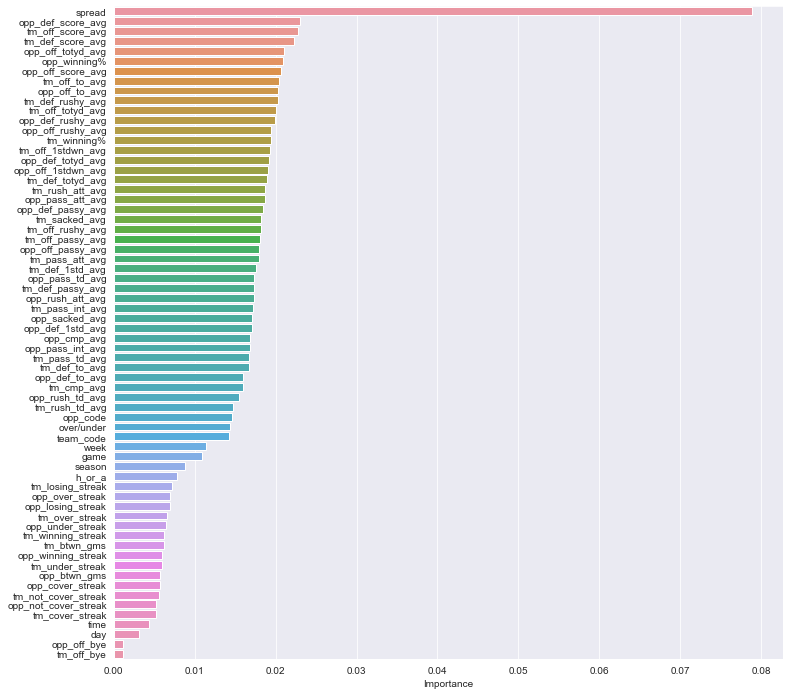

In [7]:
# use RandomForestClassifier for feature selection
clf = RandomForestClassifier(n_estimators = 100, random_state = 50)

model = clf.fit(X,y)

feat_importances = pd.DataFrame(model.feature_importances_, index = X.columns, columns = ['Importance'])
feat_importances.sort_values(by = 'Importance', ascending = False, inplace = True)

# visual of important features
sns.set_style('darkgrid')
plt.figure(figsize=(12,12))
sns.barplot(y = feat_importances.index, x = feat_importances.Importance)
plt.show()

In [8]:
# top features (all with importance of 0.015 or higher)
top_feat = []
for i in range(len(feat_importances)):
    if feat_importances['Importance'][i] > 0.015:
        top_feat.append(feat_importances['Importance'].index[i])
        
print(top_feat)

['spread', 'opp_def_score_avg', 'tm_off_score_avg', 'tm_def_score_avg', 'opp_off_totyd_avg', 'opp_winning%', 'opp_off_score_avg', 'tm_off_to_avg', 'opp_off_to_avg', 'tm_def_rushy_avg', 'tm_off_totyd_avg', 'opp_def_rushy_avg', 'opp_off_rushy_avg', 'tm_winning%', 'tm_off_1stdwn_avg', 'opp_def_totyd_avg', 'opp_off_1stdwn_avg', 'tm_def_totyd_avg', 'tm_rush_att_avg', 'opp_pass_att_avg', 'opp_def_passy_avg', 'tm_sacked_avg', 'tm_off_rushy_avg', 'tm_off_passy_avg', 'opp_off_passy_avg', 'tm_pass_att_avg', 'tm_def_1std_avg', 'opp_pass_td_avg', 'tm_def_passy_avg', 'opp_rush_att_avg', 'tm_pass_int_avg', 'opp_sacked_avg', 'opp_def_1std_avg', 'opp_cmp_avg', 'opp_pass_int_avg', 'tm_pass_td_avg', 'tm_def_to_avg', 'opp_def_to_avg', 'tm_cmp_avg', 'opp_rush_td_avg']


In [9]:
# review correlations
corr = X.corr()
corr

,season,week,game,day,time,tm_off_bye,opp_off_bye,tm_btwn_gms,opp_btwn_gms,h_or_a,...,opp_losing_streak,opp_winning_streak,opp_not_cover_streak,opp_cover_streak,opp_under_streak,opp_over_streak,spread,over/under,team_code,opp_code
season,1.000000e+00,-4.605980e-03,0.000370,2.652835e-02,2.367488e-02,0.001440,0.001440,-0.001437,-0.001437,0.000000e+00,...,0.002809,0.011643,0.001785,0.007292,0.040670,-0.050469,1.047577e-17,1.364267e-01,0.000492,0.000492
week,-4.605980e-03,1.000000e+00,0.997759,1.115658e-01,-1.322807e-02,-0.037083,-0.037083,-0.016190,-0.016190,1.496160e-18,...,0.112698,0.102539,0.061210,0.066593,0.129371,0.045086,4.694640e-18,-3.908149e-02,-0.000119,-0.000119
game,3.695243e-04,9.977593e-01,1.000000,1.123506e-01,-1.300648e-02,-0.064868,-0.042762,-0.036848,-0.020494,-1.062049e-03,...,0.110959,0.101001,0.061680,0.065327,0.127717,0.045370,7.539598e-04,-3.840354e-02,-0.001025,-0.000345
day,2.652835e-02,1.115658e-01,0.112351,1.000000e+00,3.999521e-01,-0.069969,-0.069969,-0.333778,-0.333778,-3.256371e-18,...,0.002407,0.029363,0.013559,-0.004388,0.014915,0.002253,-6.095309e-19,9.915287e-03,0.010326,0.010326
time,2.367488e-02,-1.322807e-02,-0.013006,3.999521e-01,1.000000e+00,-0.003984,-0.003984,-0.069326,-0.069326,-6.035012e-18,...,-0.075217,0.084213,-0.011059,0.006959,-0.012318,-0.004112,-8.538524e-18,1.251414e-01,0.054842,0.054842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
opp_over_streak,-5.046912e-02,4.508600e-02,0.045370,2.253115e-03,-4.112104e-03,-0.014140,0.033975,-0.013822,0.039811,-1.247096e-02,...,-0.023395,0.028905,-0.011459,0.008341,-0.516026,1.000000,3.450005e-02,1.377431e-01,0.008548,0.022216
spread,1.047577e-17,4.694640e-18,0.000754,-6.095309e-19,-8.538524e-18,-0.012565,0.012565,-0.012304,0.012304,3.472071e-01,...,-0.279510,0.263973,-0.154859,0.142033,-0.019056,0.034500,1.000000e+00,-3.478332e-17,-0.018230,0.018230
over/under,1.364267e-01,-3.908149e-02,-0.038404,9.915287e-03,1.251414e-01,0.021127,0.021127,0.023126,0.023126,6.252880e-18,...,-0.098682,0.113541,-0.004975,0.041619,-0.142957,0.137743,-3.478332e-17,1.000000e+00,0.021887,0.021887
team_code,4.917713e-04,-1.185896e-04,-0.001025,1.032553e-02,5.484211e-02,-0.001398,0.013044,-0.004820,0.020699,-1.085484e-03,...,-0.003113,-0.004355,-0.001777,0.008071,-0.013204,0.008548,-1.822963e-02,2.188662e-02,1.000000,-0.073275


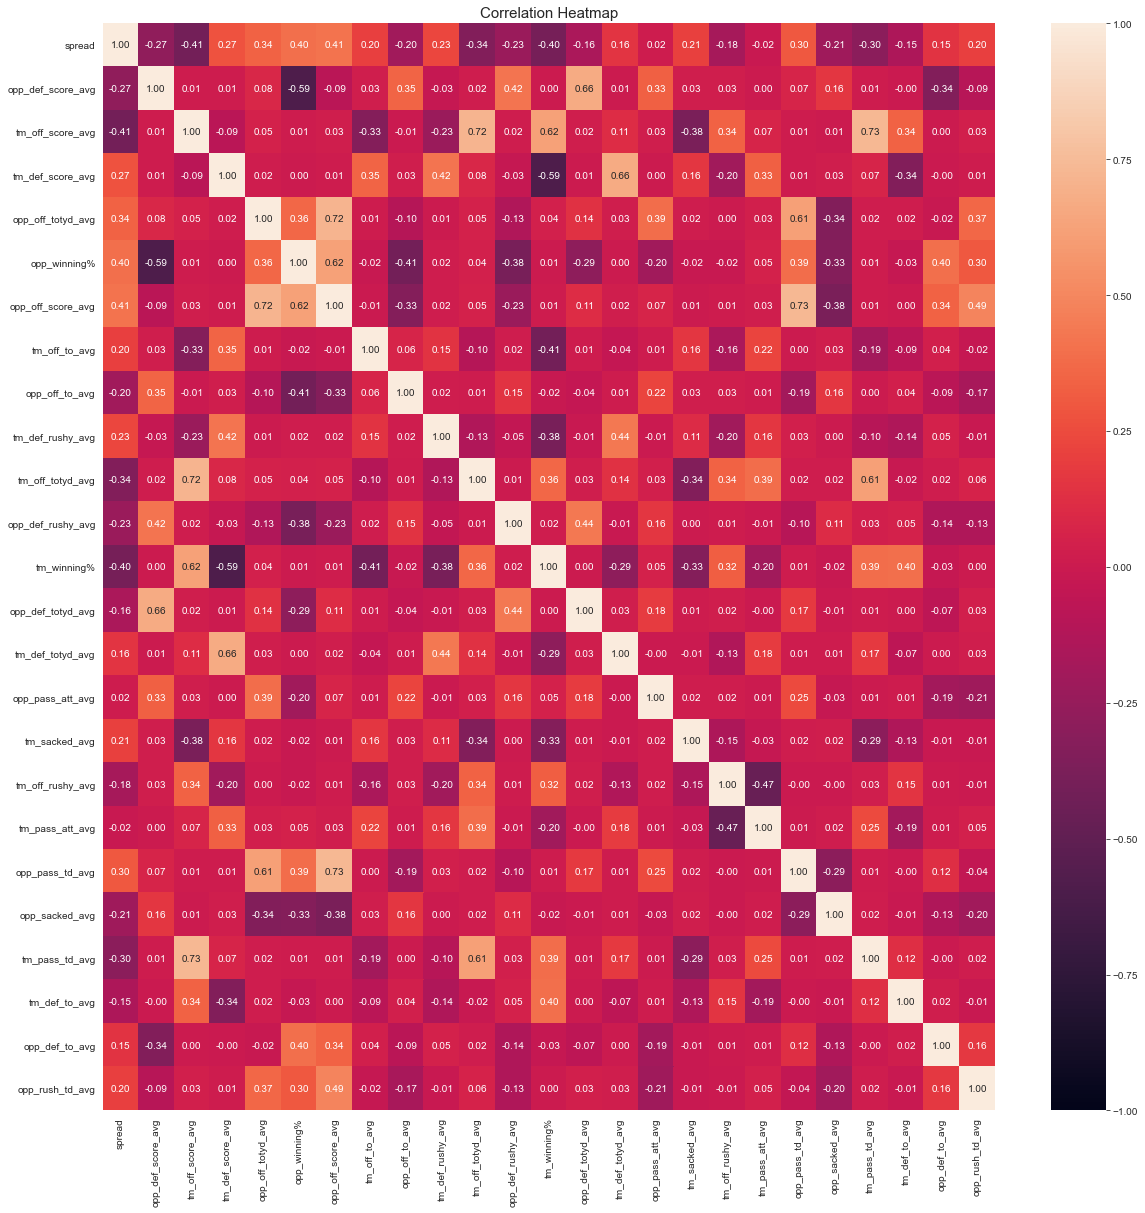

In [10]:
# further refine feature set
clean_up_more = X[['spread', 'opp_def_score_avg', 'tm_off_score_avg', 'tm_def_score_avg', 'opp_off_totyd_avg', 
                   'opp_winning%', 'opp_off_score_avg', 'tm_off_to_avg', 'opp_off_to_avg', 'tm_def_rushy_avg', 
                   'tm_off_totyd_avg', 'opp_def_rushy_avg', 'tm_winning%', 'opp_def_totyd_avg', 'tm_def_totyd_avg',
                   'opp_pass_att_avg', 'tm_sacked_avg', 'tm_off_rushy_avg', 'tm_pass_att_avg', 'opp_pass_td_avg',
                   'opp_sacked_avg', 'tm_pass_td_avg', 'tm_def_to_avg', 'opp_def_to_avg', 'opp_rush_td_avg']]
         
clean_corr = clean_up_more.corr()
                  
# correlation heat map of new features
plt.figure(figsize = (20,20))
sns.heatmap(clean_corr, vmin = -1, vmax =1, annot = True, fmt = '.2f')
plt.title('Correlation Heatmap', fontdict = {'fontsize':15})
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.show()

new_top_feat = clean_up_more.columns

In [11]:
# Set X as features data
X = scaled_df[new_top_feat]
X.head()

,spread,opp_def_score_avg,tm_off_score_avg,tm_def_score_avg,opp_off_totyd_avg,opp_winning%,opp_off_score_avg,tm_off_to_avg,opp_off_to_avg,tm_def_rushy_avg,...,opp_pass_att_avg,tm_sacked_avg,tm_off_rushy_avg,tm_pass_att_avg,opp_pass_td_avg,opp_sacked_avg,tm_pass_td_avg,tm_def_to_avg,opp_def_to_avg,opp_rush_td_avg
0,2.061263,-0.523920,-2.268653,-1.493836,-1.016643,1.903276,0.769780,-2.354258,0.777093,0.902451,...,-0.852526,0.724626,-2.204793,-0.232685,0.710514,0.724626,-0.911781,-2.311309,-0.771705,0.543420
1,2.299101,0.639979,-2.536750,0.349004,-0.310755,0.001513,0.591048,-0.788583,-0.005745,0.070770,...,0.077236,1.277743,-0.840529,-1.885596,1.521662,-2.040960,-1.722928,-2.311309,-0.771705,-1.800187
2,0.951352,-1.364513,-1.255842,1.221929,-0.900700,0.636702,-0.004723,-0.266691,-1.832366,1.267579,...,-1.816724,0.355881,-0.262867,-1.747853,0.710514,-0.750353,-0.911781,-1.798108,1.281099,-1.018985
3,-0.396397,0.979450,-1.330314,1.658391,-1.113831,0.001513,-0.883485,-0.005745,0.385674,2.606383,...,-1.317408,0.448067,-0.158396,-1.730635,-0.100633,0.171509,-0.506207,-1.926408,0.382997,-0.628384
4,1.981984,-1.332183,-0.946041,1.842675,-0.252783,0.636702,-0.719648,-0.475448,-0.005745,2.947169,...,-0.163813,0.503379,-0.125211,-1.596336,-0.641398,-1.119098,0.061596,-1.079626,-1.028306,0.543420


In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 50)

# number of samples in each set
print('Samples in training set:', X_train.shape[0])
print('Samples in testing set:', X_test.shape[0])

Samples in training set: 3832
Samples in testing set: 958


In [13]:
# Evaluation of models using Confusion Matrix, Precision, Recall, F1 Score
# simple function for calculating and displaying metrics
def model_metrics(m):
    print('Train mean accuracy:', round(cross_val_score(m, X_train, y_train, cv = 10, scoring = 'accuracy').mean(), 4))
    print('Test mean accuracy:', round(cross_val_score(m, X_test, y_test, cv = 10, scoring = 'accuracy').mean(), 4))
    print('')
    print(classification_report(y_test, m.predict(X_test), zero_division = 0))
    cm = confusion_matrix(y_test, m.predict(X_test))
    plt.figure(figsize=(10, 5))
    heatmap = sns.heatmap(cm, annot = True, fmt = "d", annot_kws={"size": 20},
                cbar = False, cmap = 'Blues_r', 
                xticklabels = ['Loss', 'Win'], yticklabels = ['Loss', 'Win'])
    heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize = 15)
    heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize = 15, rotation = 0)
    plt.show()

In [14]:
# Random Forest
# Create the parameter grid
param_grid = {'bootstrap': [True], 'max_depth': [None], 'min_samples_leaf': [2, 3, 4, 5, 6], 
              'min_samples_split': [2, 4, 6], 'n_estimators': [100, 200, 300]}

# Create a based model
rf = RandomForestClassifier(random_state = 50)

# Instantiate the grid search model
grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10, n_jobs = -1)
start_time = time.time()

grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.658914 using {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Execution time: 220.47108006477356 ms


Train mean accuracy: 0.656
Test mean accuracy: 0.6356

              precision    recall  f1-score   support

           0       0.69      0.63      0.66       510
           1       0.62      0.68      0.65       448

    accuracy                           0.66       958
   macro avg       0.66      0.66      0.66       958
weighted avg       0.66      0.66      0.66       958



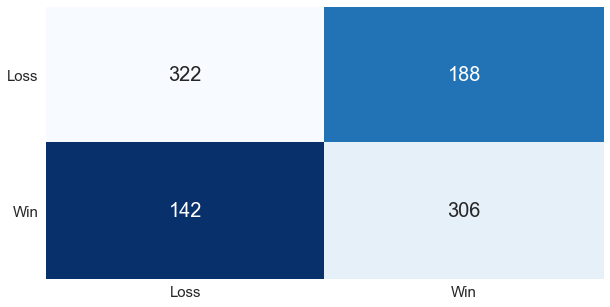

In [15]:
clf_rf_win = RandomForestClassifier(bootstrap = True, max_depth = None,
                                min_samples_leaf = 4, min_samples_split = 2, n_estimators = 200)  
clr_rf_win = clf_rf_win.fit(X_train, y_train)
model_metrics(clr_rf_win)

# dump the trained random forest classifier with Pickle
file = '..\\Pickles\\clf_rf_win.pkl'

# open the file to save as pkl file
clf_rf_win_pkl = open(file, 'wb')
pickle.dump(clf_rf_win, clf_rf_win_pkl)

# close the pickle instances
clf_rf_win_pkl.close()

In [16]:
# Logistic Regression
# Create the parameter grid
param_grid = {'dual': [True,False], 'max_iter': [100, 200, 300, 500, 1000], 'C': [1.0, 1.5, 2.0, 2.5, 3.0]}

# Create a based model
lr = LogisticRegression(penalty = 'l2', random_state = 50)

# Instantiate the grid search model
grid = GridSearchCV(estimator = lr, param_grid = param_grid, cv = 10, n_jobs = -1)
start_time = time.time()

grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.666229 using {'C': 1.0, 'dual': False, 'max_iter': 100}
Execution time: 1.8998353481292725 ms


Train mean accuracy: 0.6662
Test mean accuracy: 0.6377

              precision    recall  f1-score   support

           0       0.69      0.66      0.67       510
           1       0.63      0.66      0.65       448

    accuracy                           0.66       958
   macro avg       0.66      0.66      0.66       958
weighted avg       0.66      0.66      0.66       958



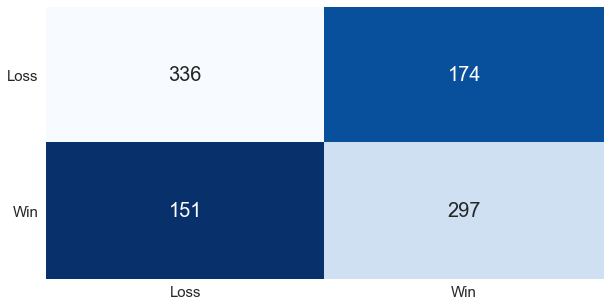

In [17]:
clf_log_reg_win = LogisticRegression(C = 1.0, dual = False, max_iter = 100)
clf_log_reg_win = clf_log_reg_win.fit(X_train, y_train)
model_metrics(clf_log_reg_win)

# dump the trained logistic regression classifier with Pickle
file = '..\\Pickles\\clf_log_reg_win.pkl'

# open the file to save as pkl file
clf_log_reg_win_pkl = open(file, 'wb')
pickle.dump(clf_log_reg_win, clf_log_reg_win_pkl)

# close the pickle instances
clf_log_reg_win_pkl.close()

Best k value is 71


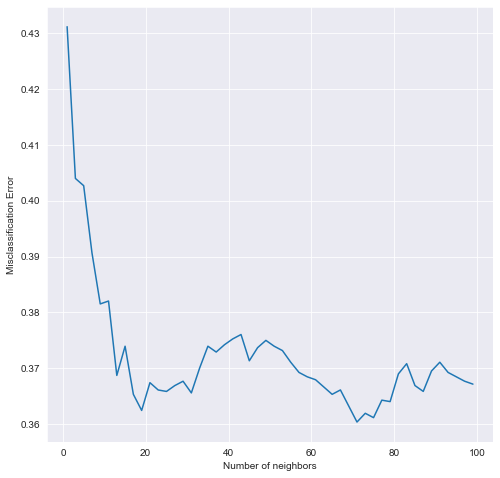

In [18]:
# K Nearest Neighbor
# Perform 10 fold cross validation
neighbors = []
cv_scores = []

for k in range(1, 100, 2):
    np.random.seed(20)
    neighbors.append(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_train, y_train, cv = 10, scoring = 'accuracy')
    cv_scores.append(scores.mean())

# Misclassification error versus k
MSE = [1-x for x in cv_scores]

# Determinethe best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('Best k value is', optimal_k)

# Plot misclassification error versus k
plt.figure(figsize=(8, 8))
sns.set_style('darkgrid')
plt.plot(neighbors, MSE)
plt.xlabel('Number of neighbors')
plt.ylabel('Misclassification Error')
plt.show()

Train mean accuracy: 0.6396
Test mean accuracy: 0.6325

              precision    recall  f1-score   support

           0       0.67      0.64      0.66       510
           1       0.61      0.65      0.63       448

    accuracy                           0.64       958
   macro avg       0.64      0.64      0.64       958
weighted avg       0.64      0.64      0.64       958



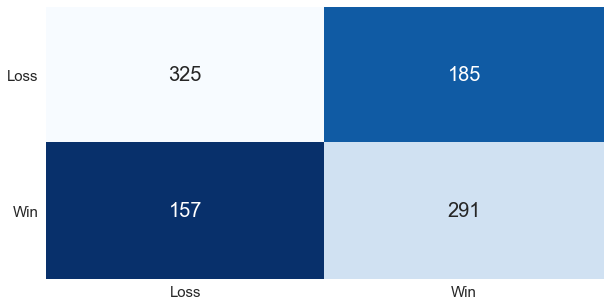

In [19]:
knn_win = KNeighborsClassifier(n_neighbors = optimal_k)
knn_win = knn_win.fit(X_train, y_train)
model_metrics(knn_win)

# dump the trained KNN classifier with Pickle
file = '..\\Pickles\\knn_win.pkl'

# open the file to save as pkl file
knn_win_pkl = open(file, 'wb')
pickle.dump(knn_win, knn_win_pkl)

# close the pickle instances
knn_win_pkl.close()

Train mean accuracy: 0.6347
Test mean accuracy: 0.6293

              precision    recall  f1-score   support

           0       0.66      0.64      0.65       510
           1       0.61      0.63      0.62       448

    accuracy                           0.64       958
   macro avg       0.63      0.64      0.63       958
weighted avg       0.64      0.64      0.64       958



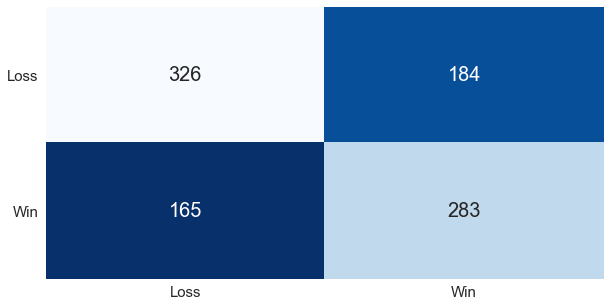

In [20]:
# Gaussian Classifier
clf_gnb_win = GaussianNB()
clf_gnb_win = clf_gnb_win.fit(X_train, y_train)
model_metrics(clf_gnb_win)

# dump the trained gaussian classifier with Pickle
file = '..\\Pickles\\clf_gnb_win.pkl'

# open the file to save as pkl file
clf_gnb_win_pkl = open(file, 'wb')
pickle.dump(clf_gnb_win, clf_gnb_win_pkl)

# close the pickle instances
clf_gnb_win_pkl.close()